**Important: This notebook will only work with fastai-0.7.x. Do not try to run any fastai-1.x code from this path in the repository because it will load fastai-0.7.x**

In [1]:
from fastai.text import *
import html

## directory setup

In [2]:
# check original path for token
!ls ../../../ChaosTheoryProject/tmp/

df_tags.csv  itos.pkl  tokens_user_flat.pkl  trn_ids.npy  val_ids.npy


In [3]:
# check original path for pretrained model
!ls ../../../pretrained_wiki/

thwiki_itos.pkl  thwiki_lm.pth


In [4]:
# create data path and copy token
DATA_PATH=Path('data_CT/data/')
DATA_PATH.mkdir(exist_ok=True)
!cp ../../../ChaosTheoryProject/tmp/tokens_user_flat.pkl data_CT/data/

In [5]:
# create lm path
LM_PATH=Path('data_CT/lm/')
LM_PATH.mkdir(exist_ok=True)

In [6]:
# make dir for temp folder
(LM_PATH/'tmp').mkdir(exist_ok=True)

In [7]:
# make dir for pretrained and copy pretrianed
PRE_PATH = Path('data_CT/models/')
PRE_PATH.mkdir(exist_ok=True)
(PRE_PATH/'wiki-thai2fit').mkdir(exist_ok=True)
!cp ../../../pretrained_wiki/thwiki_itos.pkl data_CT/models/wiki-thai2fit/
!cp ../../../pretrained_wiki/thwiki_lm.pth data_CT/models/wiki-thai2fit/

## import word token

In [8]:
# read the token
with open(f'{DATA_PATH}/tokens_user_flat.pkl','rb') as fp:
    tok_data = pickle.load(fp)

In [9]:
# split data for train & test
tok_trn = tok_data[:int(0.9*len(tok_data))]
tok_val = tok_data[int(0.9*len(tok_data)):]

In [10]:
len(tok_trn), len(tok_val)

(1091336, 121260)

In [11]:
freq = Counter(t for t in tok_trn)
freq.most_common(25)

[(' ', 215728),
 ('ที่', 16190),
 ('number', 14218),
 ('ครับ', 13641),
 ('จะ', 10128),
 ('ใน', 9789),
 ('ก็', 9596),
 ('มี', 9223),
 ('ไป', 8940),
 ('ได้', 8384),
 ('มา', 8372),
 ('ว่า', 8229),
 ('และ', 7465),
 ('เป็น', 7384),
 ('ผม', 7223),
 ('ไม่', 7132),
 ('ของ', 6808),
 ('ให้', 6459),
 ('แต่', 6438),
 ('แล้ว', 6402),
 ('ๆ', 6240),
 ('เลย', 5403),
 ('นี้', 4988),
 ('กับ', 4902),
 ('รถ', 4885)]

## encode tokens as index

In [12]:
max_vocab = 60000
min_freq = 2

In [13]:
itos = [o for o,c in freq.most_common(max_vocab) if c>min_freq]
itos.insert(0, '_pad_')
itos.insert(0, '_unk_')

We create a reverse mapping called stoi which is useful to lookup the index of a given token. stoi also has the same number of elements as itos. We use a high performance container called [collections.defaultdict](https://docs.python.org/2/library/collections.html#collections.defaultdict) to store our stoi mapping.

In [14]:
stoi = collections.defaultdict(lambda:0, {v:k for k,v in enumerate(itos)})
len(itos)

14758

In [15]:
trn_lm = np.array([[stoi[o] for o in p] for p in tok_trn])
val_lm = np.array([[stoi[o] for o in p] for p in tok_val])

In [16]:
np.save(LM_PATH/'tmp'/'trn_ids.npy', trn_lm)
np.save(LM_PATH/'tmp'/'val_ids.npy', val_lm)
pickle.dump(itos, open(LM_PATH/'tmp'/'itos.pkl', 'wb'))

trn_lm = np.load(LM_PATH/'tmp'/'trn_ids.npy')
val_lm = np.load(LM_PATH/'tmp'/'val_ids.npy')
itos = pickle.load(open(LM_PATH/'tmp'/'itos.pkl', 'rb'))

In [18]:
vs=len(itos)
vs,len(trn_lm)

(14758, 1091336)

## load pretrained thai2fit

In [19]:
em_sz,nh,nl = 400,1550,4

In [20]:
# some quick fix for version mismatch
import torch._utils
try:
    torch._utils._rebuild_tensor_v2
except AttributeError:
    def _rebuild_tensor_v2(storage, storage_offset, size, stride, requires_grad, backward_hooks):
        tensor = torch._utils._rebuild_tensor(storage, storage_offset, size, stride)
        tensor.requires_grad = requires_grad
        tensor._backward_hooks = backward_hooks
        return tensor
    torch._utils._rebuild_tensor_v2 = _rebuild_tensor_v2

model = torch.load(PRE_PATH/'wiki-thai2fit'/'thwiki_lm.pth')

In [21]:
wgts = model['model']

In [22]:
wgts

OrderedDict([('0.encoder.weight', 
              -4.5102e-02  9.4020e-02  2.6328e-01  ...  -3.5127e-01  1.6034e-02 -8.3869e-02
               4.6775e-02  1.3149e-01  4.2938e-02  ...  -3.7226e-01  1.1994e-01 -3.1550e-02
              -3.0709e-01  1.5889e-01  1.5225e-01  ...  -2.1277e-01 -2.5210e-02 -9.4852e-02
                              ...                   ⋱                   ...                
               1.1984e-03  2.3873e-01  2.0026e-02  ...  -4.4483e-01  9.1052e-04 -1.4287e-01
              -3.0914e-02  1.1426e-01 -7.9358e-02  ...  -5.2305e-01  1.7369e-01 -7.5106e-02
              -2.2116e-02  9.4815e-02 -3.9665e-02  ...  -2.5060e-01  2.9178e-01 -2.2862e-01
              [torch.cuda.FloatTensor of size 60005x400 (GPU 0)]),
             ('0.encoder_dp.emb.weight', 
              -4.5102e-02  9.4020e-02  2.6328e-01  ...  -3.5127e-01  1.6034e-02 -8.3869e-02
               4.6775e-02  1.3149e-01  4.2938e-02  ...  -3.7226e-01  1.1994e-01 -3.1550e-02
              -3.0709e-01  1

initialize word embedding weight from pretrained

In [23]:
enc_wgts = to_np(wgts['0.encoder.weight'])
row_m = enc_wgts.mean(0)

In [24]:
itos2 = pickle.load((PRE_PATH/'wiki-thai2fit'/'thwiki_itos.pkl').open('rb'))
stoi2 = collections.defaultdict(lambda:-1, {v:k for k,v in enumerate(itos2)})

In [25]:
new_w = np.zeros((vs, em_sz), dtype=np.float32)
for i,w in enumerate(itos):
    r = stoi2[w]
    new_w[i] = enc_wgts[r] if r>=0 else row_m

In [26]:
wgts['0.encoder.weight'] = T(new_w)
wgts['0.encoder_dp.emb.weight'] = T(np.copy(new_w))
wgts['1.decoder.weight'] = T(np.copy(new_w))

## Language model

In [27]:
wd=1e-7
bptt=70
bs=52
opt_fn = partial(optim.Adam, betas=(0.8, 0.99))

The goal of the LM is to learn to predict a word/token given a preceeding set of words(tokens). We take all the movie reviews in both the 90k training set and 10k validation set and concatenate them to form long strings of tokens. In fastai, we use the `LanguageModelLoader` to create a data loader which makes it easy to create and use bptt sized mini batches. The  `LanguageModelLoader` takes a concatenated string of tokens and returns a loader.

We have a special modeldata object class for LMs called `LanguageModelData` to which we can pass the training and validation loaders and get in return the model itself.

In [28]:
trn_dl = LanguageModelLoader(np.concatenate(trn_lm), bs, bptt)
val_dl = LanguageModelLoader(np.concatenate(val_lm), bs, bptt)
md = LanguageModelData(LM_PATH, 1, vs, trn_dl, val_dl, bs=bs, bptt=bptt)

We setup the dropouts for the model - these values have been chosen after experimentation. If you need to update them for custom LMs, you can change the weighting factor (0.7 here) based on the amount of data you have. For more data, you can reduce dropout factor and for small datasets, you can reduce overfitting by choosing a higher dropout factor. *No other dropout value requires tuning*

In [29]:
drops = np.array([0.25, 0.1, 0.2, 0.02, 0.15])*0.7

We first tune the last embedding layer so that the missing tokens initialized with mean weights get tuned properly. So we freeze everything except the last layer.

We also keep track of the *accuracy* metric.

In [30]:
learner= md.get_model(opt_fn, em_sz, nh, nl, 
    dropouti=drops[0], dropout=drops[1], wdrop=drops[2], dropoute=drops[3], dropouth=drops[4])

learner.metrics = [accuracy]
learner.freeze_to(-1)

In [42]:
learner.model.state_dict().keys()

odict_keys(['0.encoder.weight', '0.encoder_with_dropout.embed.weight', '0.rnns.0.module.weight_ih_l0', '0.rnns.0.module.bias_ih_l0', '0.rnns.0.module.bias_hh_l0', '0.rnns.0.module.weight_hh_l0_raw', '0.rnns.1.module.weight_ih_l0', '0.rnns.1.module.bias_ih_l0', '0.rnns.1.module.bias_hh_l0', '0.rnns.1.module.weight_hh_l0_raw', '0.rnns.2.module.weight_ih_l0', '0.rnns.2.module.bias_ih_l0', '0.rnns.2.module.bias_hh_l0', '0.rnns.2.module.weight_hh_l0_raw', '0.rnns.3.module.weight_ih_l0', '0.rnns.3.module.bias_ih_l0', '0.rnns.3.module.bias_hh_l0', '0.rnns.3.module.weight_hh_l0_raw', '1.decoder.weight'])

In [44]:
fast2pretrained_mapper = {'0.encoder_with_dropout.embed.weight':'0.encoder_dp.emb.weight',
'0.rnns.0.module.weight_hh_l0_raw':'0.rnns.0.weight_hh_l0_raw',
'0.rnns.1.module.weight_hh_l0_raw':'0.rnns.1.weight_hh_l0_raw',
'0.rnns.2.module.weight_hh_l0_raw':'0.rnns.2.weight_hh_l0_raw',
'0.rnns.3.module.weight_hh_l0_raw':'0.rnns.3.weight_hh_l0_raw'}

In [45]:
new_wgts = collections.OrderedDict()

In [46]:
for key in learner.model.state_dict().keys():
    if key in fast2pretrained_mapper:
        new_wgts[key] = wgts[fast2pretrained_mapper[key]]
    else:
        new_wgts[key] = wgts[key]

In [49]:
learner.model.load_state_dict(new_wgts)

In [50]:
lr=1e-3
lrs = lr

In [52]:
learner.fit(lrs/2, 1, wds=wd, use_clr=(32,2), cycle_len=1)

epoch      trn_loss   val_loss   accuracy                     
    0      3.431724   3.239423   0.19707   



[array([3.23942]), 0.19707024606565635]

Note that we print out accuracy and keep track of how often we end up predicting the target word correctly. While this is a good metric to check, it is not part of our loss function as it can get quite bumpy. We only minimize cross-entropy loss in the LM.

The exponent of the cross-entropy loss is called the perplexity of the LM. (low perplexity is better).

In [53]:
learner.save('lm_last_ft')

In [54]:
learner.load('lm_last_ft')

In [55]:
learner.unfreeze()

In [56]:
learner.lr_find(start_lr=lrs/10, end_lr=lrs*10, linear=True)

epoch      trn_loss   val_loss   accuracy                     
    0      1.886351   1.834894   0.504208  



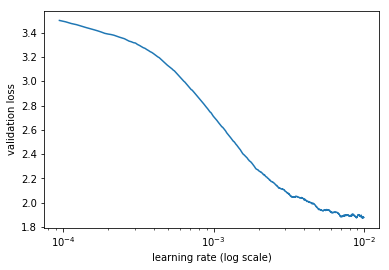

In [57]:
learner.sched.plot()

In [58]:
learner.fit(lrs, 1, wds=wd, use_clr=(20,10), cycle_len=15)

epoch      trn_loss   val_loss   accuracy                     
    0      1.952691   1.813296   0.510141  
    1      1.727431   1.626613   0.559865                     
    2      1.619      1.536573   0.583123                     
    3      1.536184   1.49491    0.595963                     
    4      1.478104   1.459113   0.605552                     
    5      1.418308   1.440864   0.610867                     
    6      1.410077   1.416643   0.615639                     
    7      1.350661   1.422479   0.620374                     
    8      1.306432   1.425102   0.622137                     
    9      1.282909   1.418708   0.624518                     
    10     1.264872   1.41758    0.626054                     
    11     1.26431    1.401287   0.627947                     
    12     1.208531   1.419211   0.629134                     
    13     1.247707   1.410038   0.630081                     
    14     1.184575   1.427028   0.629881                     



[array([1.42703]), 0.6298805415630341]

We save the trained model weights and separately save the encoder part of the LM model as well. This will serve as our backbone in the classification task model.

In [59]:
learner.save('lm1')

In [60]:
learner.save_encoder('lm1_enc')

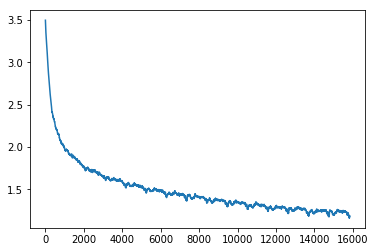

In [61]:
learner.sched.plot_loss()